In [ ]:
import numpy as np
import pandas as pd
import scipy
from pandas import DataFrame
from pandas import read_csv
import matplotlib.pyplot as plt
import glob

In [ ]:
# load KPIs files from a folder
files = glob.glob("data/data_wide_pdf90.csv")
print (files)

In [ ]:
dfs = [pd.read_csv(fp,encoding = 'gbk', low_memory=False) for fp in files]
df_raw = pd.concat(dfs, ignore_index=True)
df_raw = df_raw.iloc[3:,:].reset_index().drop(['index'], axis=1)
df_raw.rename(columns={'Unnamed: 0':'cell'}, inplace = True)
df_raw.set_index('cell', inplace = True)
df_raw = df_raw.astype("float32")
df_raw.head()

In [ ]:
feature_data = np.array(df_raw)
feature_data.shape[1]

In [ ]:
df_cellname = df_raw.index.values

In [ ]:
kpi_list = ['Users_RRC_Avg', 'PDSCH_Usage_DL',
       'PDCCH_CCE_Above_70', 'DL_Volume_GB', 'PUSCH_Usage_UL', 'UL_Volume_GB',
       'RLC_Time_Delay', 'User_THP_DL_kbps', 'User_THP_UL_kbps',
       'Cell_THP_Dl_kbps', 'Cell_THP_UL_kbps',
       'MAC_Retransmission_DL', 'MAC_Retransmission_UL', 'RLC_Retransmission_DL', 'RLC_Retransmission_UL',
       'SRfail_RAatt']

In [ ]:
nb_kpis = len(kpi_list)
nb_hours = 24
nb_features = nb_kpis * nb_hours

In [ ]:
feature_data_2d = feature_data.reshape(feature_data.shape[0], nb_kpis, nb_hours,1)

In [ ]:
# visualize a sample

# ls_feat = ['DL_PDCCH_Usage', 'DL_PDSCH_Usage', 'DL_Volume', 'UL_PUSCH_Usage', 'UL_Volume']
plt.rcParams["figure.figsize"] = (20, 10)
data =  feature_data_2d[0,:,:,0] 
#plt.xkcd()
im=plt.imshow(data, interpolation='spline16', cmap=plt.cm.get_cmap('RdYlGn_r'),aspect='auto')
#plt.clim(0,1)
plt.colorbar(im)
plt.xlabel('time (hour)')
plt.yticks(range(len(kpi_list)), kpi_list)
plt.ylabel('feature')
plt.grid(b=True, which='both', color='0.65', linestyle='--')

plt.show()

In [ ]:
from sklearn.model_selection import train_test_split

x_train, x_test = train_test_split(feature_data, test_size=0.20, random_state=42)


In [ ]:
x_train.shape[0]

In [ ]:
x_test.shape[0]

In [ ]:
from keras.layers import Input, Dense, Lambda, Layer
from keras.models import Model, load_model
from keras import backend as K
from keras import metrics

In [ ]:
# Model parameters
batch_size = 200
epochs = 80
ae_model_name = 'autoencoder'
# if create_new_ae_model == 'False':
#     # Load model
#     autoencoder = load_model(ae_model_name + '.h5')
    
#     # Load training history
#     fileObject = open((ae_model_name + '_hist'), 'r')  
#     ae_hist = pickle.load(fileObject)
#     fileObject.close()
    
# else:
    # Create Autoencoder model
    # Input feature size 792 -> compression of factor 28.5
input_img = Input(shape=(nb_features,))
encoded = Dense(64, activation='relu')(input_img)
encoded = Dense(32, activation='relu')(encoded)
encoded = Dense(16, activation='relu')(encoded)

decoded = Dense(16, activation='relu')(encoded)
decoded = Dense(32, activation='relu')(decoded)
decoded = Dense(nb_features, activation='sigmoid')(decoded)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy', metrics=['mae', 'mse', 'acc'])
#optimizer='adadelta'
#loss='mean_squared_error'
# loss='binary_crossentropy'
# metrics=['mae', 'mse', 'acc']
#validation_split=0.33

# start = time.time()
ae_hist = autoencoder.fit(x_train, x_train,
                       epochs=epochs,
                       batch_size=batch_size,
                       shuffle=True,
                       validation_data=(x_test, x_test))

ae_hist = ae_hist.history
# end = time.time()
# print("Execution time [min]: " + str((end - start)/60))

# Save model
autoencoder.save(ae_model_name + '.h5')

# Save training history
# fileObject = open((ae_model_name + '_hist'),'wb') # open the file for writing training history
# pickle.dump(ae_hist, fileObject)
# fileObject.close()


In [ ]:
# List all data in history
print(ae_hist.keys())

# Plot training stats of autoencoder model
plt.plot(ae_hist['loss'])
plt.plot(ae_hist['val_loss'])
plt.title('Training History')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [97]:
len(mse) * 0.02

368.7

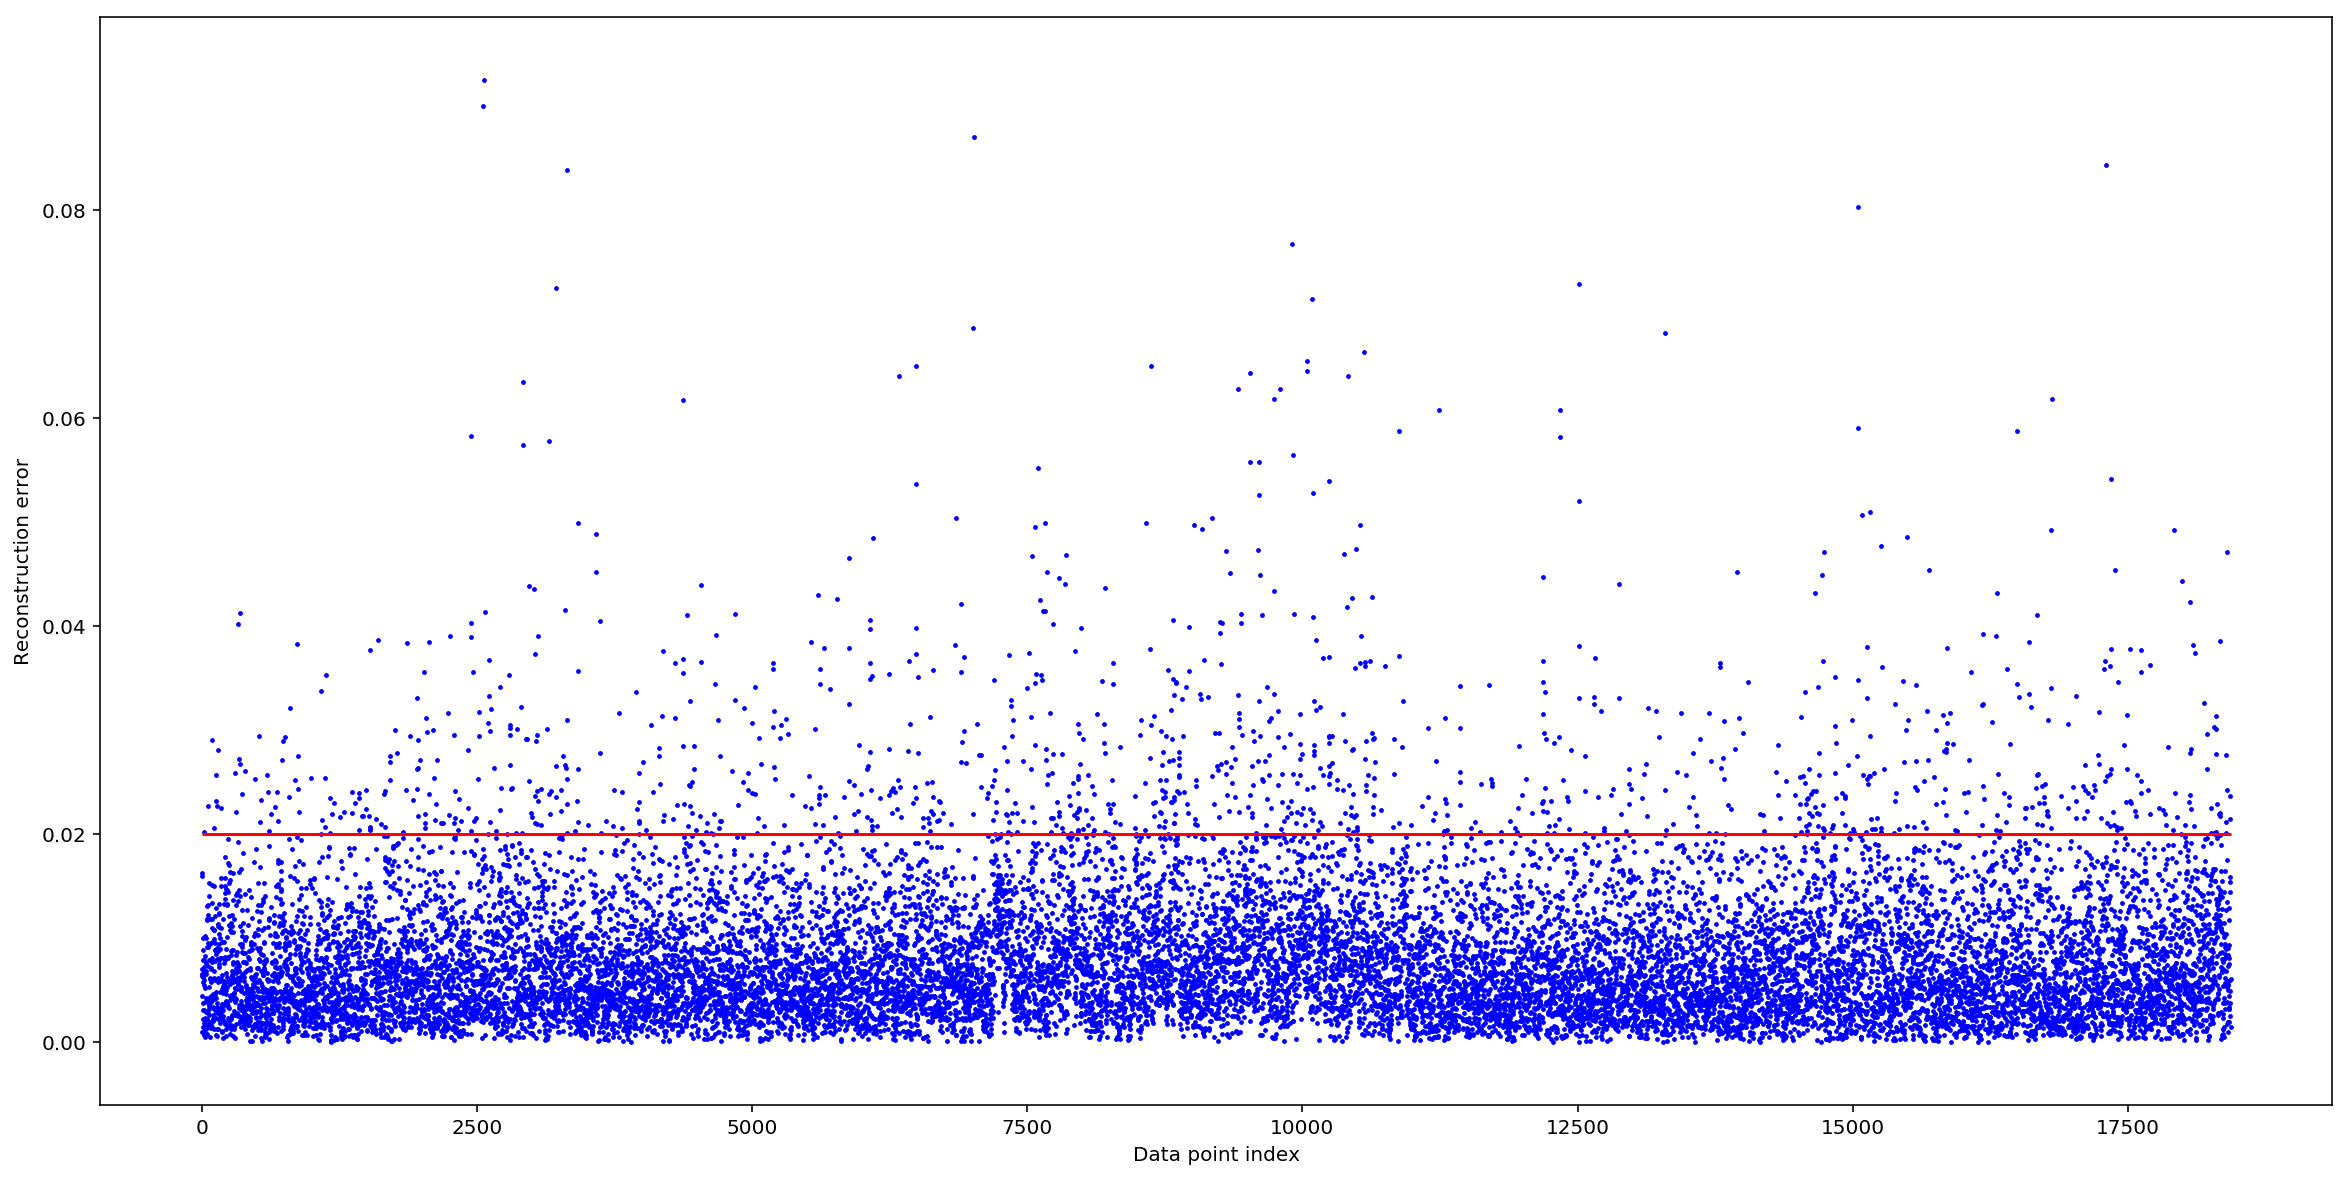

In [94]:
outlier_threshold = 0.02

# Use complete data set for anomaly detection
predictions = autoencoder.predict(feature_data)

# Compute reconstruction error
mse = np.mean(np.power(feature_data - predictions, 2), axis=1)

# Plot reconstruction error data to find outliers
fig, ax = plt.subplots()
plt.scatter(range(mse.shape[0]), mse, color='blue', s=2)
ax.hlines(outlier_threshold, 0, mse.shape[0], colors="r", zorder=100, label='Threshold')
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show()

In [ ]:
q = np.percentile(mse, [1, 99])
print(q)

x_train = feature_data

y_train = df_raw.index

y_train

In [ ]:
x_train[row_idx[0][0],:].shape

In [ ]:
np.argsort(arr_mse_sub)[::-1]

In [ ]:
import operator

def multi_plot1(x_train, relate, thresh, arr_mse, m, n):
    """
    @m <int>: 绘图中子图行数
    @n <int>: 绘图中子图列数
    """
    #get the predictions for the test data
    %matplotlib inline
    %config InlineBackend.figure_formats = {'png', 'retina'}
    #predicted_classes = np.argmax(model.predict(x_test, batch_size=10, verbose=0), axis = 1)
    img_rows = nb_kpis
    img_cols = nb_hours    

    #img_rows, img_cols = 50, 96
    ops = {'>': operator.gt,
       '<': operator.lt,
       '>=': operator.ge,
       '<=': operator.le,
       '=': operator.eq}
    
    #arr_mse = arr_mse[arr_mse[:].argsort()]
    #arr_mse[::-1].sort()

    #get the indices to be plotted
    row_idx = [np.where(ops[relate](arr_mse, thresh))] # arr_mse > thresh
    x_train_sub = x_train[row_idx[0][0],:]
#     x_train_sub = np.reshape(x_train_sub, (x_train_sub.shape[2], x_train_sub.shape[3]))
    x_train_sub = x_train_sub.reshape(x_train_sub.shape[0], img_rows, img_cols, 1)
    arr_mse_sub = arr_mse[row_idx][0]
    return  arr_mse_sub
    cell_id_sub = y_train[row_idx][0]
    # sort by mse descending
    mse_idx = np.argsort(arr_mse_sub)[::-1]  # ::-1表示倒序复制序列
    x_train_sub = x_train_sub[mse_idx]
    arr_mse_sub = arr_mse_sub[mse_idx]
    cell_id = cell_id_sub[mse_idx]

    row_idx_sub = row_idx[0][0][mse_idx]
    
    print('total cell: {} cells'.format(len(arr_mse_sub)))

    #m, n = [3,5]
    
    indx = range(x_train_sub.shape[0])

    fig = plt.figure(figsize=(20, 15))
    for i, indx in enumerate(indx[:n*m]):
        for j in range(n):
            idx = i   
            ax = fig.add_subplot(n,m,idx+1)  # n*m子图  当前绘制第idx+1个图（自左向右 自上向下）
            
            #im = ax.imshow(r_normalize(x_train_sub[indx,:,:,0]), interpolation='spline16', cmap=plt.cm.get_cmap('RdYlGn_r'))
            #im.set_clim(vmin=lower_val, vmax=upper_val)
            
            im = ax.imshow(x_train_sub[indx,:,:,0], interpolation='spline16', cmap=plt.cm.get_cmap('RdYlGn_r'))
            im.set_clim(vmin=0, vmax=1) #max_value = -81.53, min_value = -182.00
            #plt.title("MSE {}".format((round(arr_mse[indx], 6))))
            plt.title("MSE {0:.3g}, \n i:{1}, ci: {2}".format(arr_mse_sub[indx], row_idx_sub[indx], cell_id[indx]), color='red')
            plt.tight_layout()

    cax = fig.add_axes([1, 0.1, 0.01, 0.8])
    fig.colorbar(im, cax=cax)
    
    plt.show()
    
   
multi_plot1(x_train, ">", np.percentile(mse, 99), mse, 1, 10)

In [ ]:
multi_plot1(x_train, "<", np.percentile(mse, 2), mse, 1, 10)

In [ ]:
q = np.percentile(mse, [2, 98])
print(q)

In [ ]:
outlier_threshold = q[1]

outlier_data = feature_data[np.where(mse > outlier_threshold)[0],:]

outlier_cellname =  df_cellname[np.where(mse > outlier_threshold)[0]]

outlier_mse = mse[np.where(mse > outlier_threshold)[0]]

outlier_data.shape[0]

In [ ]:
normal_threshold = q[0]

normal_data = feature_data[np.where(mse < normal_threshold)[0],:]

normal_cellname =  df_cellname[np.where(mse < normal_threshold)[0]]

normal_mse = mse[np.where(mse < normal_threshold)[0]]

normal_data.shape[0]

In [ ]:
# 包含异常和正常的混合数据
mix_data = np.concatenate((outlier_data,normal_data),axis=0)
mix_cellname = np.concatenate((outlier_cellname,normal_cellname),axis=0)
mix_mse =  np.concatenate((outlier_mse,normal_mse),axis=0)
mix_data.shape[0]

In [ ]:
outlier_data.shape

In [ ]:
# 对异常数据进行聚类
from sklearn.cluster import KMeans

numClusters = 5

# Compute k-means clustering
kmeans = KMeans(n_clusters=numClusters)
kmeans.fit(outlier_data)

km_centroids = kmeans.cluster_centers_
km_labels = kmeans.labels_

# 2-dim scatter plot
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 10))

colors=['b','g','r','c','m','y','k','chocolate','gold','lightgrey', 'skyblue', 'lime']

for i in range(numClusters):
    ax.scatter(outlier_data[km_labels==i, 0], outlier_data[km_labels==i, 1], 
           c=colors[i], edgecolor='k', label=i)

ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')

ax.set_title('T-SNE 2D Analysis')
ax.legend()

plt.show()

In [ ]:
# # Plot normal patterns
# for label in range(numClusters):
#     label_pattern_data = outlier_data[np.where(km_labels==label)[0],:]
#     label_cellname_data = outlier_cellname[np.where(km_labels==label)[0]]
#     label_mse_data = outlier_mse[np.where(km_labels==label)[0]]
#     n = label_pattern_data.shape[0]  # how many ouliers we will display
#     f = plt.figure(figsize=(10, 4*n))
#     for i in range(n):
#         # display original
#         ax = plt.subplot((n/1)+1, 1, i + 1)
#         plt.imshow(np.transpose(label_pattern_data[i,:].reshape(nb_hours, nb_kpis,order = 'F')), interpolation='spline16', cmap=plt.cm.get_cmap('RdYlGn_r'),aspect='auto')
# #         ax.get_xaxis().set_visible(False)
# #         ax.get_yaxis().set_visible(False)
#     #     ax.set_title(label_pattern_data[i])
#         plt.yticks(range(len(kpi_list)), kpi_list)
#         plt.title('Cell: = {0} MSE = {1:.3g}'.format(label_cellname_data[i],label_mse_data[i]))
#         plt.grid(b=True, which='both', color='0.65', linestyle='--')
#     plt.show()

#     f.savefig("high_load_class0"+str(label)+".pdf", bbox_inches='tight')

In [ ]:
data_pca_tsne.shape

In [95]:
outlier_data.shape

(369, 384)

In [ ]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

data_pca= PCA(n_components=60).fit_transform(outlier_data)

data_pca_tsne = TSNE(n_components=2).fit_transform(data_pca)

from sklearn.cluster import KMeans

numClusters = 5

# Compute k-means clustering
kmeans = KMeans(n_clusters=numClusters)
kmeans.fit(data_pca_tsne)

km_centroids = kmeans.cluster_centers_
km_labels = kmeans.labels_

# 2-dim scatter plot
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 10))

colors=['b','g','r','c','m','y','k','chocolate','gold','lightgrey', 'skyblue', 'lime']

for i in range(numClusters):
    ax.scatter(data_pca_tsne[km_labels==i, 0], data_pca_tsne[km_labels==i, 1], 
           c=colors[i], edgecolor='k', label=i)

ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')

ax.set_title('T-SNE 2D Analysis')
ax.legend()

plt.show()

In [ ]:
x_tmp_arr = outlier_data.reshape(outlier_data.shape[0],  nb_kpis, nb_hours)

import matplotlib as mpl


from PIL import Image
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import matplotlib.patches as patches

# ------------------------------------------------------------------------------

def imscatter(points, images, ax, zoom, scale01):
    for (x, y), image in zip(points, images):
        if scale01==True:
            im = OffsetImage(image, zoom=zoom, interpolation='spline16', norm=mpl.colors.Normalize(vmin=0, vmax=1), cmap=plt.cm.get_cmap('RdYlGn_r'))
        elif scale01==False:
            im = OffsetImage(image, zoom=zoom, interpolation='spline16', cmap=plt.cm.get_cmap('RdYlGn_r'))
            
        ab = AnnotationBbox(im, (x, y), frameon=True, pad=0.2)
        ax.add_artist(ab)

# ------------------------------------------------------------------------------


# np.min(x_tmp_arr), np.max(x_tmp_arr)


# x_min, x_max = 0, 1
# x_tmp_arr_norm = (x_tmp_arr - x_min) / (x_max - x_min)


fig, ax = plt.subplots(figsize = (20, 16))

# Create ten random points.
#N_SAMPLES = 10
#points = np.random.random((N_SAMPLES,2)) * 500

Xp = data_pca_tsne[:, 0]
Yp = data_pca_tsne[:, 1]

ax.set_xlim([Xp.min().astype(int), Xp.max().astype(int)])
ax.set_ylim([Yp.min().astype(int), Yp.max().astype(int)])

imscatter(data_pca_tsne, x_tmp_arr, ax, 5, scale01 = True)


In [ ]:
outlier_data.shape[0]

In [ ]:
outlier_mse[np.where(km_labels==0)[0]]

In [ ]:
import matplotlib as mpl
# Plot abnormal patterns
for label in range(numClusters):
    label_pattern_data = outlier_data[np.where(km_labels==label)[0],:]
    label_cellname_data = outlier_cellname[np.where(km_labels==label)[0]]
    label_mse_data = outlier_mse[np.where(km_labels==label)[0]]
    n = label_pattern_data.shape[0]  # how many ouliers we will display
    label_pattern_data = label_pattern_data.reshape(label_pattern_data.shape[0],nb_kpis,nb_hours, 1)
    f = plt.figure(figsize=(20, 2*n))
    for i in range(n):
        # display original
        ax = plt.subplot((n+1)/2, 2, i + 1)
        plt.imshow(label_pattern_data[i,:,:,0],norm=mpl.colors.Normalize(vmin=0, vmax=1), interpolation='None', cmap=plt.cm.get_cmap('RdYlGn_r'),aspect='auto')
#         ax.get_xaxis().set_visible(False)
#         ax.get_yaxis().set_visible(False)
    #     ax.set_title(label_pattern_data[i])
#         plt.colorbar()
        plt.yticks(range(len(kpi_list)), kpi_list)
        plt.title('Cell: = {0} MSE = {1:.3g}'.format(label_cellname_data[i],label_mse_data[i]))
        plt.grid(b=True, which='both', color='0.65', linestyle='--')
    plt.show()

    f.savefig("high_load_class0"+str(label)+".pdf", bbox_inches='tight')

In [ ]:
label_pattern_data = outlier_data[np.where(km_labels==0)[0],:]
label_cellname_data = outlier_cellname[np.where(km_labels==0)[0]]
label_mse_data = outlier_mse[np.where(km_labels==0)[0]]

In [ ]:
# Plot normal patterns
n = label_pattern_data.shape[0]  # how many ouliers we will display
f = plt.figure(figsize=(20, 30))
for i in range(n):
    # display original
    ax = plt.subplot((n+1)/5, 5, i + 1)
    plt.imshow(np.transpose(label_pattern_data[i,:].reshape(nb_hours, nb_kpis,order = 'F')),norm=mpl.colors.Normalize(vmin=0, vmax=1), interpolation='spline16', cmap="RdYlGn_r")
#     ax.get_xaxis().set_visible(False)
#     ax.get_yaxis().set_visible(False)
    plt.colorbar()
#     ax.set_title(label_pattern_data[i])
    #plt.yticks(range(len(kpi_list)), kpi_list)
    plt.title('Cell: = {0} MSE = {1:.3g}'.format(label_cellname_data[i],label_mse_data[i]))
plt.show()